In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

from bounds import * 

########### DATA STRUCTURE NOTES ############
# v[y,t,d]
# - contains oracle values for v[y,t,0] if they exist
# - contains values for v[y,t,1]

# Vpf_up = [y,t]
# - contains upper bound for v_y(t,0) in each entry

# Vpf_down = [y,t]
# - contains lower bound for v_y(t,0) in each entry
##############################################


In [2]:

nrange = np.arange(0.03,.97,.1)
N = len(nrange) ** 4

v = np.zeros((2,2,2,N))
Vpf_down = np.ones((2,2,N))*.0001 #prevent division by zero
Vpf_up = np.zeros((2,2,N))

n = 0

# Vary identified terms v[y,t,1]
for a in nrange:
    for b in nrange:
        for c in nrange:
            for d in nrange:
                n += 1 
                if a + b + c + d <= 1:
                    v[0,0,1,n] = a
                    v[0,1,1,n] = b
                    v[1,0,1,n] = c
                    v[1,1,1,n] = d

# Populate unidentified terms v[y,t,0] satisfying sum v[y,t,d] = 1. 
# Not uniform sampling but that's fine for our purposes
for n in range(N): 
    s = 1-v[:,:,1,n].sum()
    ubs = np.random.rand(2,2)
    v[:,:,0,n] = (s * ubs) / ubs.sum()
    
# Populate worst case bounds Vpf_down, Vpf_up based on a constraint from p(.)   
for n in range(N): 
    rho_10 = v[0,1,0,n] + v[1,1,0,n]
    Vpf_up[0,1,n] = rho_10 
    Vpf_up[1,1,n] = rho_10 

    rho_00 = v[0,0,0,n] + v[1,0,0,n]
    Vpf_up[0,0,n] = rho_00
    Vpf_up[1,0,n] = rho_00
    
    
# Check all cells sum to one
for n in range(N):
    assert np.abs(v[:,:,:,n].sum() - 1) < .001


In [10]:
u = np.array([[1,0], [0, 1]])
metrics = ['m_y=1', 'm_y=0', 'm_a=0', 'm_a=1', 'm_u']

# Why are these greater than one? Is this an issue? 
gamma_0 = Vpf_up[0,0,:] + Vpf_up[0,1,:] + v[0,1,1,:] + v[0,0,1,:]
gamma_1 = Vpf_up[1,0,:] + Vpf_up[1,1,:] + v[1,0,1,:] + v[1,1,1,:]
pD = 1 - (v[0,0,1,:] + v[0,1,1,:] + v[1,0,1,:] + v[1,1,1,:])
pT = 1 - (v[0,1,0,:] + v[0,1,1,:] + v[1,1,0,:] + v[1,1,1,:])
alpha = Vpf_up[0,0,:] - Vpf_down[0,0,:]

# Measures for regret seperation plot
D_y1 = alpha*v[1,1,1]/ (gamma_1**2)
D_y0 = alpha*v[0,1,1]/ (gamma_0**2)
D_a0 = alpha/np.max([pD, pT],axis=0)
D_u =  alpha * (u[0,0] + u[0,1])

bounds = {
    'Rd_down': [],
    'Rd_up': [],
    'Rs_down': [],
    'Rs_up': [],
    'R_oracle': [],
    'metric': [],
    'u_00': [],
    'u_01': [],
    'u_10': [],
    'u_11': [],
    'D_y0':[],
    'D_y1':[],
    'D_a0':[],
    'D_u':[]
}

# Check positive and negative class performance, PPV
for n in range(N):
    for metric in metrics: 
        Rd_down, Rd_up = delta_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, metric)
        Rs_down, Rs_up = standard_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, metric)
        R_oracle = oracle_regret(v[:,:,:,n], u, metric)
        
        try:
            assert Rd_down < Rd_up, f'Bound ordinality check: {Rd_down:.3} < {Rd_up:.3} violated for n={n}'
            assert Rs_down < Rs_up
            assert Rd_down-.02 <= R_oracle and R_oracle <= Rd_up+.02
            assert Rs_down-.02 <= R_oracle and R_oracle <= Rs_up+.02

        except: 
            print(f'metric: {metric}')
            print(f'Standard bounds [{Rs_down:.3}, {Rs_up:.3}]')
            print(f'Delta bounds: [{Rd_down:.3}, {Rd_up:.3}]')
            print(f'Oracle: {R_oracle:.4}')
            print()
            
        bounds['Rd_down'].append(Rd_down)
        bounds['Rd_up'].append(Rd_up)
        bounds['Rs_down'].append(Rs_down)
        bounds['Rs_up'].append(Rs_up)
        bounds['R_oracle'].append(R_oracle)
        bounds['metric'].append(metric)
        bounds['u_00'].append(u[0,0])
        bounds['u_01'].append(u[0,1])
        bounds['u_10'].append(u[1,0])
        bounds['u_11'].append(u[1,1])
        bounds['D_y0'].append(D_y0[n])
        bounds['D_y1'].append(D_y1[n])
        bounds['D_a0'].append(D_a0[n])
        bounds['D_u'].append(D_u[n])
        
        
        
# Check utilities over varying ranges
utils = [.01,.5,.9]
for n in range(N):
    for ua in utils:
        for ub in utils:
            for uc in utils:
                for ud in utils:
                    u = np.array([[ua,ub],[uc,ud]])
                    Rd_down, Rd_up = delta_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, 'm_u')
                    Rs_down, Rs_up = standard_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, 'm_u')
                    R_oracle = oracle_regret(v[:,:,:,n], u, 'm_u')
                    
                    try:
                        assert Rd_down <= Rd_up+.001, f'Bound ordinality check: {Rd_down:.3} < {Rd_up:.3} violated for n={n}'
                        assert Rs_down <= Rs_up+.001
                        assert Rd_down-.02 <= R_oracle and R_oracle <= Rd_up+.02
                        assert Rs_down-.02 <= R_oracle and R_oracle <= Rs_up+.02

                    except: 
                        print('N:', n)
                        print('U:', ua, ub, uc, ud)
                        print(f'Standard bounds [{Rs_down:.3}, {Rs_up:.3}]')
                        print(f'Delta bounds: [{Rd_down:.3}, {Rd_up:.3}]')
                        print(f'Oracle: {R_oracle:.4}')
                        print()
                        
                    bounds['Rd_down'].append(Rd_down)
                    bounds['Rd_up'].append(Rd_up)
                    bounds['Rs_down'].append(Rs_down)
                    bounds['Rs_up'].append(Rs_up)
                    bounds['R_oracle'].append(R_oracle)
                    bounds['metric'].append(metric)
                    bounds['u_00'].append(u[0,0])
                    bounds['u_01'].append(u[0,1])
                    bounds['u_10'].append(u[1,0])
                    bounds['u_11'].append(u[1,1])
                    bounds['D_y1'].append(D_y1[n])
                    bounds['D_y0'].append(D_y0[n])
                    bounds['D_a0'].append(D_a0[n])
                    bounds['D_u'].append(D_u[n])

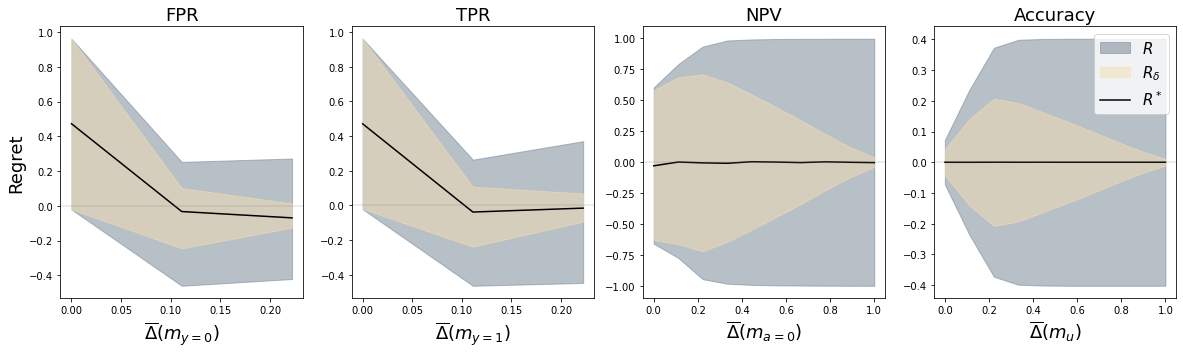

In [16]:
bdf = pd.DataFrame(bounds)
bkeys = ['D_y0', 'D_y1', 'D_a0', 'D_u']
metrics = ['m_y=0', 'm_y=1', 'm_a=0', 'm_u']
metric_names = ['FPR', 'TPR', 'NPV', 'Accuracy']
xnames = ['$\overline{\Delta}(m_{y=0})$', '$\overline{\Delta}(m_{y=1})$',
          '$\overline{\Delta}(m_{a=0})$', '$\overline{\Delta}(m_u)$']

n_plots = len(metrics)
n_bins = 9
fig, axs = plt.subplots(1, n_plots, figsize=(5*n_plots, 5), sharey=False)

for ix, bkey in enumerate(bkeys):

    mdf = bdf[bdf['metric'] == metrics[ix]]
    mdf[bkey] = ((mdf[bkey]*n_bins).round()/n_bins).copy()
    mdf = mdf.groupby([bkey]).mean().reset_index()
    mdf = mdf.sort_values(by=bkey, ascending=True)
    
    axs[ix].fill_between(mdf[bkey], mdf['Rs_down'],mdf['Rs_up'], color='#708090', alpha=.5, label='$R$')
    axs[ix].fill_between(mdf[bkey], mdf['Rd_down'], mdf['Rd_up'], color='#F5DEB3', alpha=.5, label='$R_{\delta}$')

    axs[ix].plot(mdf[bkey], mdf[f'R_oracle'], color='k', label='$R^*$')
    axs[ix].set_title(metric_names[ix], fontsize=18)
    axs[ix].set_xlabel(xnames[ix], fontsize=18)
    axs[ix].axhline(color='grey', alpha=.2)

axs[0].set_ylabel('Regret', fontsize=18)
plt.legend(fontsize=15)
plt.savefig('figs/seperation.pdf', dpi=500, bbox_inches='tight')

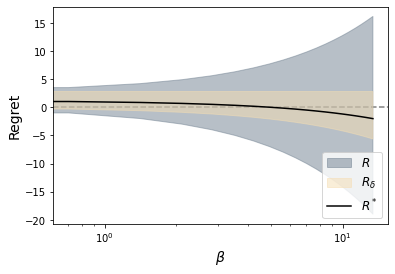

In [21]:

bounds = {
    'Rd_down': [],
    'Rd_up': [],
    'Rs_down': [],
    'Rs_up': [],
    'R_oracle': [],
    'metric': [],
    'u_00': [],
    'u_01': [],
    'u_10': [],
    'u_11': [],
    'D_y0':[],
    'D_y1':[],
    'D_a0':[],
    'D_u':[]
}

n=D_u.argsort()[9000]
for u00 in range(20):
    for u11 in range(20):

        u = np.array([[u00,0],[0,u11]])

        Rd_down, Rd_up = delta_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, 'm_u')
        Rs_down, Rs_up = standard_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, 'm_u')
        R_oracle = oracle_regret(v[:,:,:,n], u, 'm_u')

        try:
            assert Rd_down <= Rd_up+.001, f'Bound ordinality check: {Rd_down:.3} < {Rd_up:.3} violated for n={n}'
            assert Rs_down <= Rs_up+.001
            assert Rd_down-.02 <= R_oracle and R_oracle <= Rd_up+.02
            assert Rs_down-.02 <= R_oracle and R_oracle <= Rs_up+.02

        except: 
            print('N:', n)
            print('U:', ua, ub, uc, ud)
            print(f'Standard bounds [{Rs_down:.3}, {Rs_up:.3}]')
            print(f'Delta bounds: [{Rd_down:.3}, {Rd_up:.3}]')
            print(f'Oracle: {R_oracle:.4}')
            print()

        bounds['Rd_down'].append(Rd_down)
        bounds['Rd_up'].append(Rd_up)
        bounds['Rs_down'].append(Rs_down)
        bounds['Rs_up'].append(Rs_up)
        bounds['R_oracle'].append(R_oracle)
        bounds['metric'].append(metric)
        bounds['u_00'].append(u[0,0])
        bounds['u_01'].append(u[0,1])
        bounds['u_10'].append(u[1,0])
        bounds['u_11'].append(u[1,1])
        bounds['D_y1'].append(D_y1[n])
        bounds['D_y0'].append(D_y0[n])
        bounds['D_a0'].append(D_a0[n])
        bounds['D_u'].append((u[0,0]+u[0,1])*alpha[n])   

bdf = pd.DataFrame(bounds)
udf = bdf[(bdf['metric'] == 'm_u') & (bdf['u_01'] == 0) & (bdf['u_10'] == 0)]

udf['ur'] = udf['u_00'] / udf['u_11']
udf = udf.sort_values(by='D_u')
udf = udf.groupby('D_u').mean().reset_index()

plt.axhline(0, color='grey', zorder=1, linestyle='--')

plt.fill_between(udf['D_u'], udf['Rs_down'], udf['Rs_up'], color='#708090', alpha=.5, label='$R$')
plt.fill_between(udf['D_u'], udf['Rd_down'], udf['Rd_up'], color='#F5DEB3', alpha=.5, label='$R_{\delta}$')
plt.plot(udf['D_u'], udf['R_oracle'], color='k', label='$R^*$')
plt.xscale('log',base=10) 
plt.legend(loc='lower right', fontsize=12)


plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('Regret', fontsize=14)
plt.savefig('figs/seperation_utility.pdf', dpi=500, bbox_inches='tight')